In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datatable as dt
import datetime
import seaborn as sns
from functions import *
from os import path
from wordcloud import WordCloud
from matplotlib.pyplot import figure

# [RQ1] After collecting information, the Data Scientists have to know what dataset they are dealing with, so let's start with an Exploratory Data Analysis (EDA). What can you say about our datasets? Please summarise its main characteristics with visual and tabular methods.

## Preprocessing

Before loading the whole dataset of posts, let's have a look at it's structure and how the variable are stored to see if there is a bettere way to read and store the information

In [2]:
post = pd.read_csv("instagram_posts.csv", delimiter="\t", chunksize=2000000)
posts = post.get_chunk(2000000)
profiles = pd.read_csv("instagram_profiles.csv", delimiter="\t")
locations = pd.read_csv("instagram_locations.csv", delimiter = "\t")

In [3]:
posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   sid              int64  
 1   sid_profile      int64  
 2   post_id          object 
 3   profile_id       float64
 4   location_id      float64
 5   cts              object 
 6   post_type        int64  
 7   description      object 
 8   numbr_likes      int64  
 9   number_comments  int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 152.6+ MB


In [4]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4509586 entries, 0 to 4509585
Data columns (total 11 columns):
 #   Column               Dtype  
---  ------               -----  
 0   sid                  int64  
 1   profile_id           float64
 2   profile_name         object 
 3   firstname_lastname   object 
 4   description          object 
 5   following            float64
 6   followers            float64
 7   n_posts              float64
 8   url                  object 
 9   cts                  object 
 10  is_business_account  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 378.5+ MB


In [5]:
locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022658 entries, 0 to 1022657
Data columns (total 23 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   sid                     1022658 non-null  int64  
 1   id                      1022658 non-null  int64  
 2   name                    1022658 non-null  object 
 3   street                  715704 non-null   object 
 4   zip                     715579 non-null   object 
 5   city                    937166 non-null   object 
 6   region                  1760 non-null     object 
 7   cd                      939010 non-null   object 
 8   phone                   601688 non-null   object 
 9   aj_exact_city_match     1000510 non-null  object 
 10  aj_exact_country_match  1000510 non-null  object 
 11  blurb                   406705 non-null   object 
 12  dir_city_id             495698 non-null   object 
 13  dir_city_name           495698 non-null   object 
 14  di

### Handle Na values

As we can see we have a lot of Na values in multiple columns. We are gonna drop all the rows that contains an Na value in it


In [6]:
posts = posts.dropna()
profiles = profiles.dropna()
location = locations.dropna()

As we can see from the info() function, all the attributes are not efficiently stored as they use a data types, that is most of the times unneccessary, so right now we will convert the data type of each dataframe to the appropriate one

In [7]:
posts.describe().T

,count,mean,std,min,25%,50%,75%,max
sid,1829661.0,2.889080e+07,2.592478e+06,6025.0,28799208.0,2.933446e+07,2.986832e+07,3.041944e+07
sid_profile,1829661.0,2.455931e+05,8.391523e+05,-1.0,-1.0,-1.000000e+00,-1.000000e+00,4.510554e+06
profile_id,1829661.0,3.050861e+09,3.484867e+09,4.0,284850346.0,1.548651e+09,5.227030e+09,1.443827e+10
location_id,1829661.0,3.196241e+14,5.806375e+14,982.0,287312639.0,9.524707e+08,3.340913e+14,1.015010e+16
post_type,1829661.0,1.061260e+00,2.398203e-01,1.0,1.0,1.000000e+00,1.000000e+00,3.000000e+00
numbr_likes,1829661.0,3.118932e+02,6.145873e+03,0.0,21.0,4.900000e+01,1.280000e+02,2.212264e+06
number_comments,1829661.0,7.677924e+00,1.818650e+02,0.0,0.0,2.000000e+00,6.000000e+00,1.352210e+05


Convert posts Dtype:

As we can see, we can modify the memory of a few columns, in particular:
- number_comments has a range going from 0 to 135221 so we can use the int32
- numbr_likes has a range going from 0 to 135221 so we can use the int32
- post_likes rappresents only 3 possibility, so a categorical feature should be good enough
- sid_profile has a range going from -1 to 4510554 so we can use the int32
- sid has a range going from 6025 to 30419436 so we can use the int 32

Let's change the dtype for the posts dataset

In [8]:
dtypes = {
    'sid': 'int32',
    'sid_profile': 'int32',
    'post_id':'object',
    'profile_id': 'float64',
    'location_id': 'float64',
    'cts' : 'object',
    'post_type' : 'category',
    'numbr_likes': 'int32',
    'number_comments':'int32'
}

In [9]:
posts = pd.read_csv("instagram_posts.csv", delimiter="\t", chunksize=2000000, dtype=dtypes)
p_clean = posts.get_chunk(2000000)
p_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 10 columns):
 #   Column           Dtype   
---  ------           -----   
 0   sid              int32   
 1   sid_profile      int32   
 2   post_id          object  
 3   profile_id       float64 
 4   location_id      float64 
 5   cts              object  
 6   post_type        category
 7   description      object  
 8   numbr_likes      int32   
 9   number_comments  int32   
dtypes: category(1), float64(2), int32(4), object(3)
memory usage: 108.7+ MB


We went from 152MB to 109 MB for the same chunk. But we can do better by managing the Na Values!


The same process can be applied to all 3 datasets, but to make things easier for us we are gonna use the library "datatable" which will do the optimization of the attributes when reading the dataset

## Opening the Datasets with datatable

In [10]:
posts = dt.fread("instagram_posts.csv").to_pandas()
profiles = dt.fread("instagram_profiles.csv").to_pandas()
locations = dt.fread("instagram_locations.csv").to_pandas()

In [11]:
#Let's create a copy of posts which will be useful in RQ2.4
posts2=posts[['location_id','post_id']]

In [12]:
posts.dropna(inplace=True)
profiles.dropna(inplace=True)
locations.dropna(inplace=True)

## Data Visualizzation

As a lot of the further exercises require us to plot the correlation between a lot of variables we are gonna exclude those plots here and focus on something that wasn't asked in a later exercises

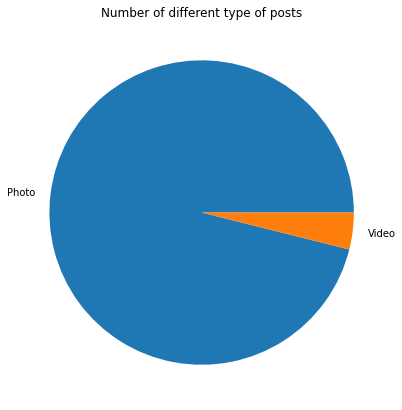

In [13]:
c = posts['post_type'].value_counts()

fig = plt.figure(figsize =(10, 7))
plt.title("Number of different type of posts")
plt.pie(c, labels=['Photo', 'Video', ' '])
plt.show()

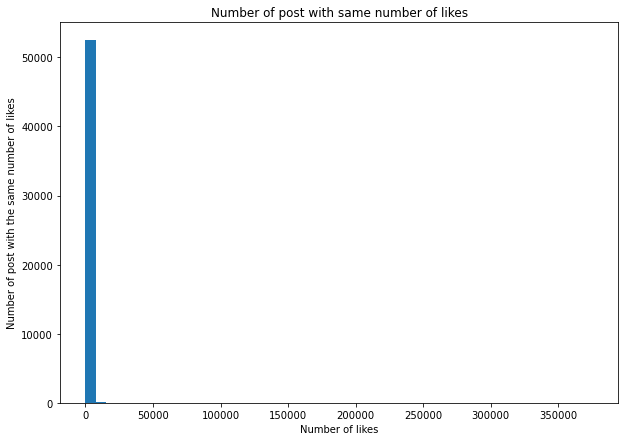

In [14]:
same_likes = posts['numbr_likes'].value_counts()

fig = plt.figure(figsize =(10, 7))
plt.title("Number of post with same number of likes")
plt.xlabel("Number of likes")
plt.ylabel("Number of post with the same number of likes")
plt.hist(same_likes, bins = 50)
plt.show()

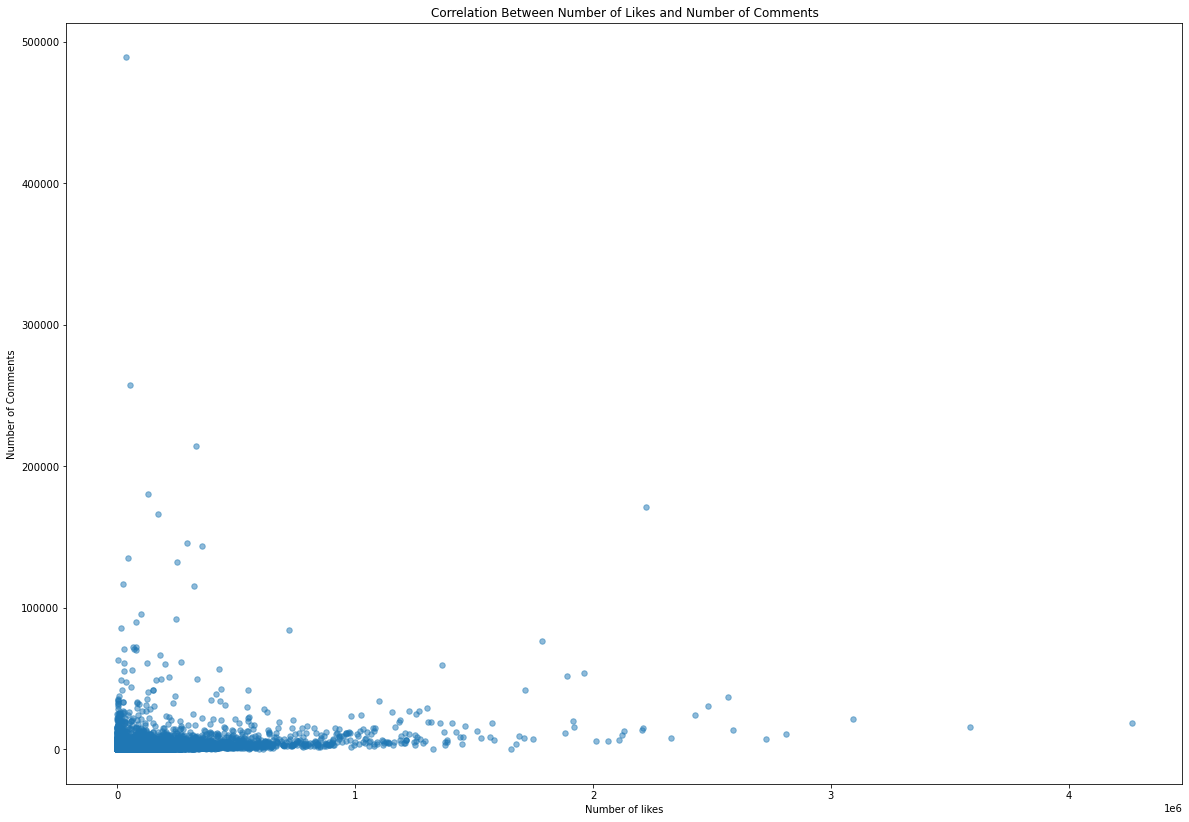

In [15]:
fig = plt.figure(figsize =(20, 14))
plt.scatter(posts['numbr_likes'], posts['number_comments'],s=30, alpha=0.5)
plt.xlabel("Number of likes")
plt.ylabel("Number of Comments")
plt.title("Correlation Between Number of Likes and Number of Comments")
plt.show()

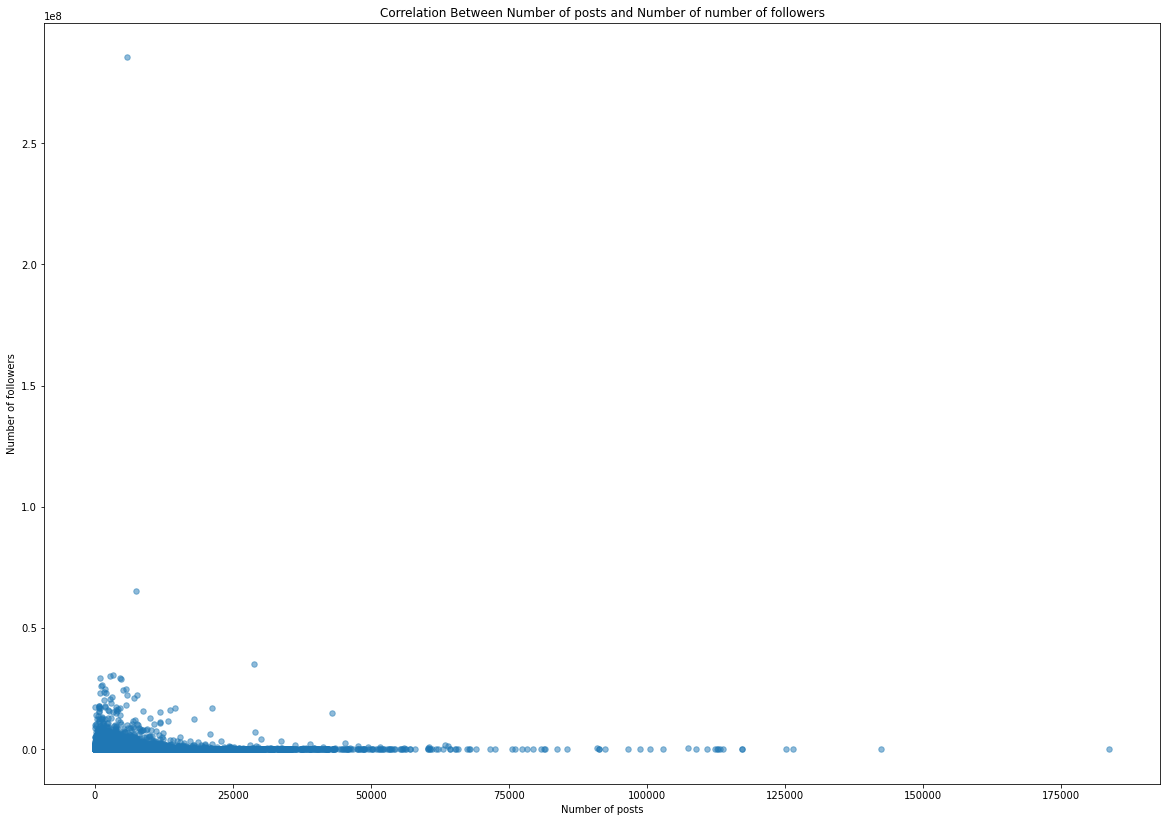

In [16]:
fig = plt.figure(figsize =(20, 14))
plt.scatter(profiles['n_posts'], profiles['followers'],s=30, alpha=0.5)
plt.xlabel("Number of posts")
plt.ylabel("Number of followers")
plt.title("Correlation Between Number of posts and Number of number of followers")
plt.show()

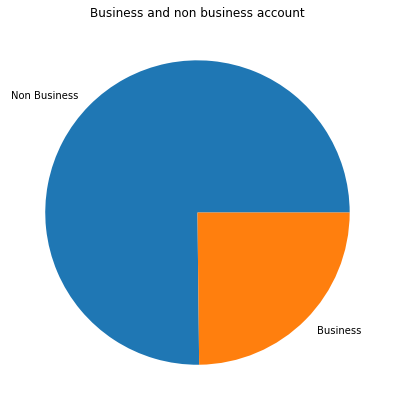

In [17]:
is_business = profiles['is_business_account'].value_counts()

fig = plt.figure(figsize =(10, 7))
plt.title("Business and non business account")
plt.pie(is_business, labels=['Non Business', 'Business'])
plt.show()

# [RQ2] Let's explore the dataset by finding simple insights regarding the profile and posts.

## RQ2.1: Plot the number of posts for each profile in descending order.


In [18]:
#Let's select the column that we need
profiles2 = profiles[['profile_name','n_posts']]

#Order by "n_posts", ascending = False
profiles2=profiles2.sort_values('n_posts', ascending=False)

#Count the number of posts for each profiles
count_post=profiles2.groupby('n_posts').count()

#Remove the 0, and sum
count_post.iloc[1:].sum()

profile_name    3247911
dtype: int64

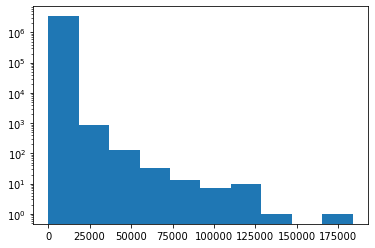

In [19]:
#Plot the histogram
h=profiles2['n_posts']
plt.hist(h,log=True)
plt.show()

What can we say about this result?

As we can see, the majority of the instagram profiles have no posts, meanwhile only a small proportion have posted more than 125.000 posts.

## RQ2.2 What posts have the highest number of "likes"?

This is the top 10 of most liked posts

In [20]:
#Sort the values of by the column "numbr_likes" and select the top 10
df=posts[['post_id','numbr_likes']].sort_values(by='numbr_likes', ascending=False).head(10)

#Reset the index
df.index=['Post '+str(i+1) for i in range(10)]

#Show the top 10
df.head(10)

,post_id,numbr_likes
Post 1,BqSLFVBFLfq,4264745.0
Post 2,BwTSXBKg7gN,3586546.0
Post 3,BxxY17hhQv8,3091301.0
Post 4,BujmsmnAt8M,2813469.0
Post 5,BsB9YrrFvIV,2726066.0
Post 6,BsAwJ1_nFiy,2590353.0
Post 7,BvsgLsSlr_e,2566721.0
Post 8,Bur6m7eAG6t,2483834.0
Post 9,BnRF3aph5_-,2429228.0
Post 10,BxLzya6FN6U,2329077.0


## RQ2.3 What posts have the most and the least number of comments?

In [22]:
#Select the columns that we are interested in 
comments=posts[['post_id','number_comments']]

#Sort the df by the columns "number_comments", ascending = False, to find the top
top_comm=comments.sort_values(by='number_comments', ascending=False)

#Sort the df by the columns "number_comments", ascending = True, to find the bottom
least_comm=comments.sort_values(by='number_comments', ascending=True)

In [23]:
#This is the top 10 of posts which have the most number of comments
top_comm.head(10)

,post_id,number_comments
41873060,Bx2sPAjHviO,488953.0
33261751,BJ-rkpTgn1N,257488.0
11149127,BMtisIxjhtT,214365.0
5427268,BoQoM-JFkPA,180635.0
6220011,Bt4qlVDAZMH,170836.0
14257307,Bzqb95QI_1E,166198.0
11149135,BQXgfR4jIjd,145806.0
28934415,BfggQmkhmoU,143614.0
242837,BQ_N0bzhTSL,135221.0
11149124,BYgXWqeDZv0,132162.0


In [24]:
#These are the 10 posts which have the least number of comments
least_comm.head(10)


#There are many posts with zero comment, these are only ten of them, randomly

,post_id,number_comments
0,BXdjjUlgcgq,0.0
7501363,BxIk3V0JQHj,0.0
7501365,BxFrui_pADZ,0.0
7501366,BxFaCanB8Pp,0.0
7501369,BxFIgq8JH02,0.0
7501370,BxFIWOnFsoy,0.0
7501372,BxFGP0IJ7oM,0.0
7501373,BxFF-D3FHv0,0.0
28356123,BvmWFcyBfuo,0.0
7501374,BylAKZoHhAE,0.0


## RQ2.4 How many posts include tagged locations, and how many do not? Show it using an appropriate chart and comment your results.

In [25]:
#Here we use the copy posts2

#Select all the rows without Na values in it
yes_location= len(posts2[np.isnan(posts2['location_id']) == False])

#Select all the rows with Na values in it
no_location = len(posts2[np.isnan(posts2['location_id']) == True])

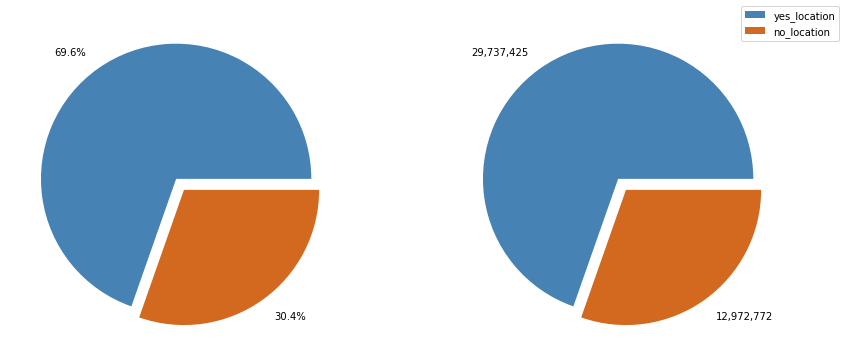

In [26]:
#Showing the result using a pie chart, which is very usefull to catch the difference between the 
total_posts=yes_location+no_location
yes_perc='{:.1%}'.format(yes_location/total_posts)
no_perc='{:.1%}'.format(no_location/total_posts)
myexplode=[0.0,0.1]

#The plots
fig, axs = plt.subplots(1,2)
axs[0].pie([yes_location,no_location], labels=[yes_perc,no_perc], 
        labeldistance=1.15, colors=['steelblue','chocolate'], 
           explode=myexplode)
axs[1].pie([yes_location,no_location], labels=['{:,}'.format(yes_location),'{:,}'.format(no_location)], 
        labeldistance=1.15, colors=['steelblue','chocolate'], explode=myexplode)
plt.legend(['yes_location','no_location'], bbox_to_anchor=(0.85,1.025), loc="upper left")

# Some cool features
fig.tight_layout(pad=2.0)
fig.set_figheight(15)
fig.set_figwidth(15)
plt.show() #remove the annoying text

#### What did we get?

As we can see, the pie chart hightlights how small is the percentage of posts that do not include a tagged position. On the other side, the majority of the analyzed posts include tagged location.

## RQ2.5 How many posts include only photos? How many also have videos?

In [27]:
#first we groupBy and count by "post_type"
total=posts[['post_type','post_id']].groupby('post_type').count()

#number of post that incluse photos
photos=int(total.values[0])

#number of video that include videos
photos_and_videos=int(total.values[2])

In [28]:
print('The posts that include only photos are: ','{:,}'.format(photos))

print('The posts that include both photos and videos are: ','{:,}'.format(photos_and_videos))

The posts that include only photos are:  27,508,521
The posts that include both photos and videos are:  49


## RQ2.6 What's the percentage of business accounts vs non-business? What can you interpret regarding that percentage?

In [29]:
#Let's select the variables we are interested in 
profiles2 = profiles[['is_business_account','profile_name']]

# Cool, now let's count how many business account
Business_account=len(profiles2[profiles2['is_business_account'] == True])

# Now let's count how many NOT business account
Not_business_account= len(profiles[profiles['is_business_account'] == False])

In [30]:
#Now let's give a look at the percentage of Business Account on the total amount of accounts
'{:.1%}'.format(Business_account/(Business_account+Not_business_account))

'24.8%'

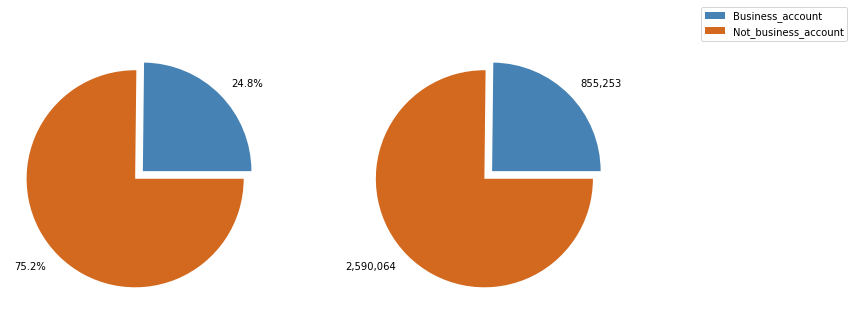

In [31]:
#Showing the result using a pie chart, which is very usefull to catch the difference between the 
total_account=Business_account+Not_business_account
yes_perc='{:.1%}'.format(Business_account/total_account)
no_perc='{:.1%}'.format(Not_business_account/total_account)
myexplode=[0.0,0.1]

#The plots
fig, axs = plt.subplots(1,2, figsize=(8,8))
axs[0].pie([Business_account,Not_business_account], labels=[yes_perc,no_perc], 
        labeldistance=1.15, colors=['steelblue','chocolate'], 
           explode=myexplode)
axs[1].pie([Business_account,Not_business_account], labels=['{:,}'.format(Business_account),'{:,}'.format(Not_business_account)], 
        labeldistance=1.15, colors=['steelblue','chocolate'], explode=myexplode)
plt.legend(['Business_account','Not_business_account'], bbox_to_anchor=(1.25,1.125), loc="upper left")

# Some cool features
fig.tight_layout(pad=2.0)
fig.set_figheight(15)
fig.set_figwidth(15)
plt.show() #remove the annoying text

Since the percentage of business account on the total account is 24.8%, it means that for 3 non-business account there is a business account on our dataset. 

# [RQ3] Now it's important to understand the most common times in which users publish their posts

## RQ3.1 What is the most common time in which users publish their posts?

In [32]:
#Let's select the variables we are interested in 
posts2=posts[['cts','post_id']]
posts2['cts'] = pd.to_datetime(posts2['cts']).dt.time

#Now let's count how many posts there are for each time
total_time=posts2.groupby('cts').count()

#reset the index
total_time.reset_index(inplace=True)

#Then sort it and select the 5 most common time
top_5_times= total_time.sort_values('post_id',ascending=False).head(5)

top_5_times['cts'].head()

/var/folders/f8/5qj1kgpj0jv663dcg8r4dqwr0000gn/T/ipykernel_66056/2504140422.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts2['cts'] = pd.to_datetime(posts2['cts']).dt.time


75609    21:00:09
64829    18:00:29
75604    21:00:04
72012    20:00:12
72003    20:00:03
Name: cts, dtype: object

In [33]:
# Then the most common time
most_common_time=top_5_times[['cts']].head(1)
for i in most_common_time.cts:
    print('The most common time in which users publish their posts is '+ str(i)+'.')


The most common time in which users publish their posts is 21:00:09.


## RQ3.2 Create a function that receives a time intervals list as a parameter and returns a plot with the number of posts for each given interval.

The function created for this Task can be seen in the "functions.py" files in the main repository, it is called **time_intervals**.

## RQ3.3 Use the function that you created in the previous literal to plot the number of posts between the following time intervals:
| Initial time | Final time   |
|--------------|--------------|
|   06:00:00   |    10:59:59  |
|   11:00:00   |    13:59:59  |
|   14:00:00   |    16:59:59  |
|   17:00:00   |    19:59:59  |
|   20:00:00   |    23:59:59  |
|   00:00:00   |    02:59:59  |
|   03:00:00   |    05:59:59  |



/Users/the_redd_/Desktop/ADM/ADM-HMW2/functions.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts2['cts'] = pd.to_datetime(posts2['cts']).dt.time


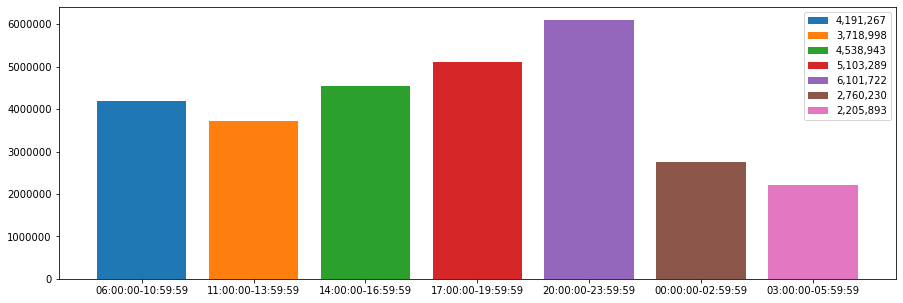

In [34]:
first_interval=[['06:00:00'],['10:59:59']]
second_interval=[['11:00:00'],['13:59:59']]
third_interval=[['14:00:00'],['16:59:59']]
fourth_interval=[['17:00:00'],['19:59:59']]
fifth_interval=[['20:00:00'],['23:59:59']]
sixth_interval=[['00:00:00'],['02:59:59']]
seventh_interval=[['03:00:00'],['05:59:59']]

intervals=[first_interval,second_interval,third_interval,fourth_interval,fifth_interval,sixth_interval,seventh_interval]

time_intervals(posts,intervals,'post_id')

As we can see, the users mainly prefer to post between 20:00:00 and 23:59:59, while from 03:00:00 to 05:59:59 is the most uncommon time to post.

# [RQ4] In most cases, we will not have a consistent dataset, and the one we are dealing with is not an exception (ex. in the given datasets, you may not find the information of the profiles for some of the posts). So let’s enhance our analysis.

## RQ4.1 Write a function that, given a profile_id, will be able to return the posts that belong to the given profile_id.

The function created for this Task can be seen in the "functions.py" files in the main repository, it is called **searchpost**.

In [35]:
searchpost(posts,profile_id=3.0)

,post_id,profile_id,numbr_likes,number_comments,location_id,post_type,cts
1781533,EQltd,3.0,390.0,27.0,1.444006e+06,1,2011-05-15 04:33:23
1939650,vY,3.0,92.0,5.0,2.166905e+08,1,2010-09-05 21:48:24
2665638,QK72l,3.0,1295.0,23.0,2.435929e+08,1,2011-10-15 05:12:17
3111012,SYx-3pABAy,3.0,7477.0,132.0,1.029824e+09,1,2012-11-23 22:30:38
4225968,cz,3.0,115.0,8.0,8.030000e+02,1,2010-08-21 06:40:27
7017554,TxM22,3.0,3343.0,87.0,5.400000e+01,1,2011-11-12 07:12:24
7042626,NQD4KAABKF,3.0,6417.0,148.0,2.705200e+04,1,2012-07-19 07:36:52
30920283,L-RzGwgBFZ,3.0,7020.0,226.0,2.151232e+08,1,2012-06-17 13:20:48
32570511,J5pNU,3.0,1392.0,56.0,3.399500e+04,1,2011-08-11 03:13:56
33906912,NLGU6,3.0,1501.0,43.0,2.191180e+05,1,2011-09-16 01:24:41


## RQ4.2 Write another function that, given an input n (an integer), will return the posts that belong to the n top posted profiles (top n profiles that have posted the highest number of posts) that their data is available in the profile.csv using the previously written function.

The function created for this Task can be seen in the "functions.py" files in the main repository, it is called **top_posts**.

In [39]:
top_ten=top_posts(profiles,posts,10)
top_ten.head()

,profile_id,post_id,numbr_likes,number_comments,location_id,post_type,cts
9592952,199664772.0,Bq3hP3Khp8J,0.0,0.0,1.029593e+09,1.0,2018-12-02 03:03:33
9592953,199664772.0,Bq3hN53hUsD,0.0,0.0,1.029593e+09,1.0,2018-12-02 03:03:17
9592954,199664772.0,BCqCe9LypeF,27.0,0.0,1.029569e+09,1.0,2016-03-07 16:28:50
9592955,199664772.0,20Wu4zypd2,28.0,0.0,2.373984e+08,1.0,2015-05-18 11:21:27
9592956,199664772.0,BrKq76AhadU,1.0,0.0,3.213373e+08,1.0,2018-12-09 13:33:47


## RQ4.3 What is the average number of "likes" and comments of the top 10 profiles with the highest number of posts which their information is available in profile.csv?

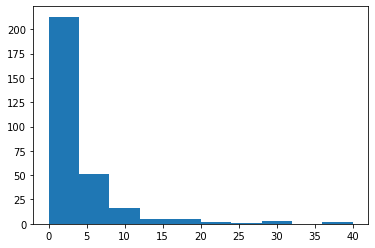

2.0

In [40]:

#Let's see the distribution of likes 
plt.hist(top_ten['numbr_likes'])
plt.show()

#The average of "likes" of the top 10 profiles with the highest number of posts
top_ten['numbr_likes'].mean()

#Let's check the median in order to know moe about our distribution
top_ten['numbr_likes'].median()

Since the median (2.0) is smaller than the average (3.17), it means that our distribution is asymmetric due to some posts which have a huge amount of likes, as matter of fact, the mean is a statistic influenced by exteme observations. On the other hand, the median is a **robust statistic** because it is not affected by outliers. In our case, we can see that half of the posts have less than 2 likes, while the other half have more than 2 likes.

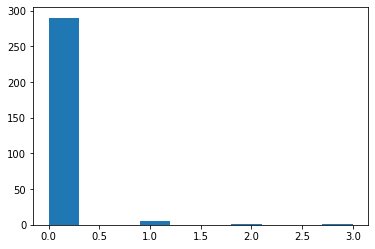

In [41]:
#Let's see the distribution of likes 
plt.hist(top_ten['number_comments'])
plt.show()

In [42]:
#The average of "comments" of the top 10 profiles with the highest number of posts
mean = top_ten['number_comments'].mean()

#The median of "comments" of the top 10 profiles with the highest number of posts
median = top_ten['number_comments'].median()

In [43]:
print("The mean: ", mean)
print("The median: ", median)

The mean:  0.03691275167785235
The median:  0.0


Taking into account the comments of the top 10 profiles with the highest number of posts, we can see how, on average, the posts show no comments, except for some posts which have less than 3. 

## RQ4.4 Plot the number of posts that these top 10 profiles have sent on Instagram in the given interval in question RQ3. Interpret the resulting chart.

/Users/the_redd_/Desktop/ADM/ADM-HMW2/functions.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts2['cts'] = pd.to_datetime(posts2['cts']).dt.time


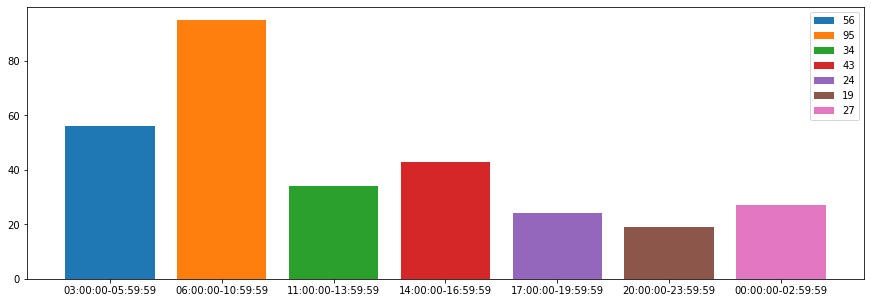

In [44]:
first_interval=[['06:00:00'],['10:59:59']]
second_interval=[['11:00:00'],['13:59:59']]
third_interval=[['14:00:00'],['16:59:59']]
fourth_interval=[['17:00:00'],['19:59:59']]
fifth_interval=[['20:00:00'],['23:59:59']]
sixth_interval=[['00:00:00'],['02:59:59']]
seventh_interval=[['03:00:00'],['05:59:59']]
intervals=[seventh_interval,first_interval,second_interval,third_interval,fourth_interval,fifth_interval,sixth_interval]


time_intervals(top_profiles,intervals,'post_id')

As we can see, considering only the top 10 profiles, the scenario changes completely. As a matter of fact, we see how the top ten profiles post mainly during the night and the early morning. On the other hand, considering all the profiles, the night is the less common time to post. More specifically, the most common interval considering all the profiles is between 20:00:00 and 23:59:59, while considering the top 10 profiles this is the most uncommon interval. 

# [RQ5] The most influential users are the ones with the highest number of “followers", you can now look more into their activity.

## RQ5.1 Plot the top 10 most popular users in terms of followers and their number of posts.

In [45]:
#Let's select the columns that we are interested in
profiles2 = profiles[['profile_name','n_posts', 'followers','profile_id']]

#Let's check for NaN values in 'n_posts'
profiles2['n_posts'].isnull().sum()

#Let's check for NaN values in 'follower'
profiles2['followers'].isnull().sum()

#Let's drop them
profiles2.dropna(inplace=True)

#Verify it
profiles2['n_posts'].isnull().sum() == profiles2['followers'].isnull().sum() == 0

#Let's sort profiles in ascending order by followers and n_posts
top_profiles=profiles2.sort_values(by=['followers','n_posts'], ascending=False).head(10)


/Users/the_redd_/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


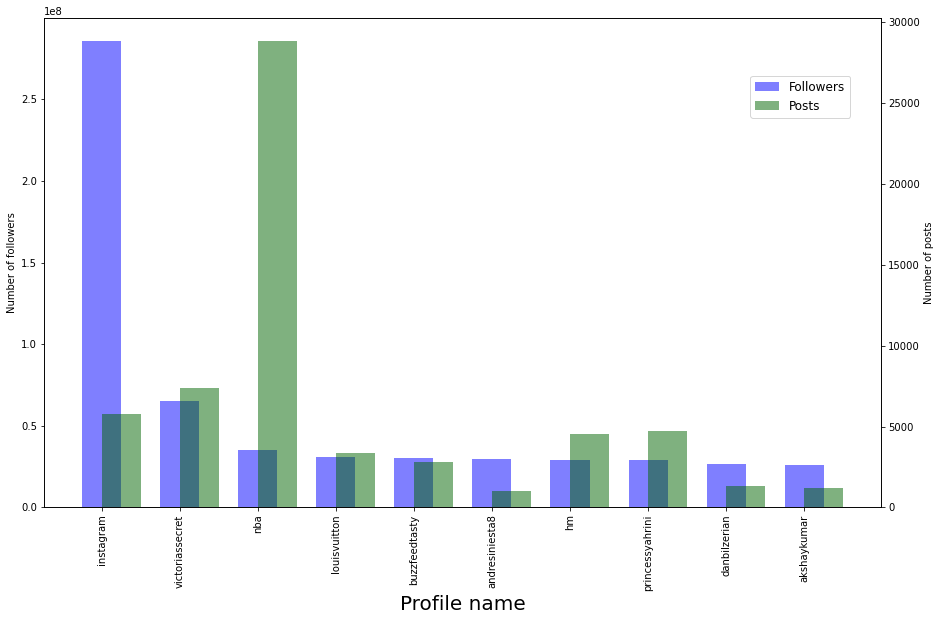

In [46]:
#Now let's plot it
#I'm using white labels because my theme on VS is dark
fig, ax1 = plt.subplots(figsize=(15, 9))
ax1.set_xlabel('Profile name',size=20)
ax1.xaxis.label.set_color('black')
ax1.yaxis.label.set_color('black')
ax1.tick_params(axis='x', colors='black')
ax1.tick_params(axis='y', colors='black')
# plot line chart on axis #1
ax1.bar(top_profiles['profile_name'], top_profiles['followers'], width=0.5, alpha=0.5, color='Blue')
ax1.set_ylabel('Number of followers')
plt.xticks(top_profiles['profile_name'], top_profiles['profile_name'], rotation='vertical')
#ax1.set_ylim(0, 25)
# set up the 2nd axis
ax2 = ax1.twinx()
ax2.yaxis.label.set_color('black')
ax2.tick_params(axis='y', colors='black')


# plot bar chart on axis #2
ax2.bar(top_profiles['profile_name'], top_profiles['n_posts'], width=0.5, alpha=0.5, color='darkgreen', align='edge')
ax2.grid(False) # turn off grid #2
ax2.set_ylabel('Number of posts')
#ax2.set_ylim(0, 90)
fig.legend(['Followers','Posts'], loc="upper center",bbox_to_anchor=(0.5, 0.3, 0.65, 0.5),fontsize='large')
plt.show()

## RQ5.2 Who is the most influential user?

In [47]:
profiles2 = profiles[['profile_name', 'followers', 'profile_id']]

#Let's check for NaN values in 'n_posts'
profiles2['followers'].isnull().sum()

#Let's drop them
profiles2.dropna(inplace=True)

#Let's check for NaN values in 'follower' again
profiles2['followers'].isnull().sum()

#Verify it
profiles2['followers'].isnull().sum() == 0

#Let's sort
sorted_profile=profiles2.sort_values(by='followers', ascending=False)

In [48]:
# Let's see the result
print('The most influential user is "',sorted_profile.head(1)['profile_name'].values[0], 
      '" with ','{:,}'.format(int(sorted_profile.head(1)['followers'])), ' followers')

The most influential user is " instagram " with  285,457,645  followers


## RQ5.3 Have they posted anything with tagged locations? Extract the most frequent areas on their posts and plot the number of times each city has been visited.

In [49]:
#Merge the 2 datasets on profile_id
df=pd.merge(posts,top_profiles, on='profile_id')
df=df[['location_id','post_id','profile_id']]

#Rename the columns from "location_id" to "id"
df.rename(columns={'location_id':'id'},inplace=True)

#Merge df and locations on the key: "id"
last_df=pd.merge(df,locations,on='id')

#Let's do a group by "city" and count every occurence
df_locations=last_df[['post_id','city']].groupby('city').count()

#Sort values by "post_id" 
new_df_locations=df_locations.sort_values(by='post_id',ascending=False)


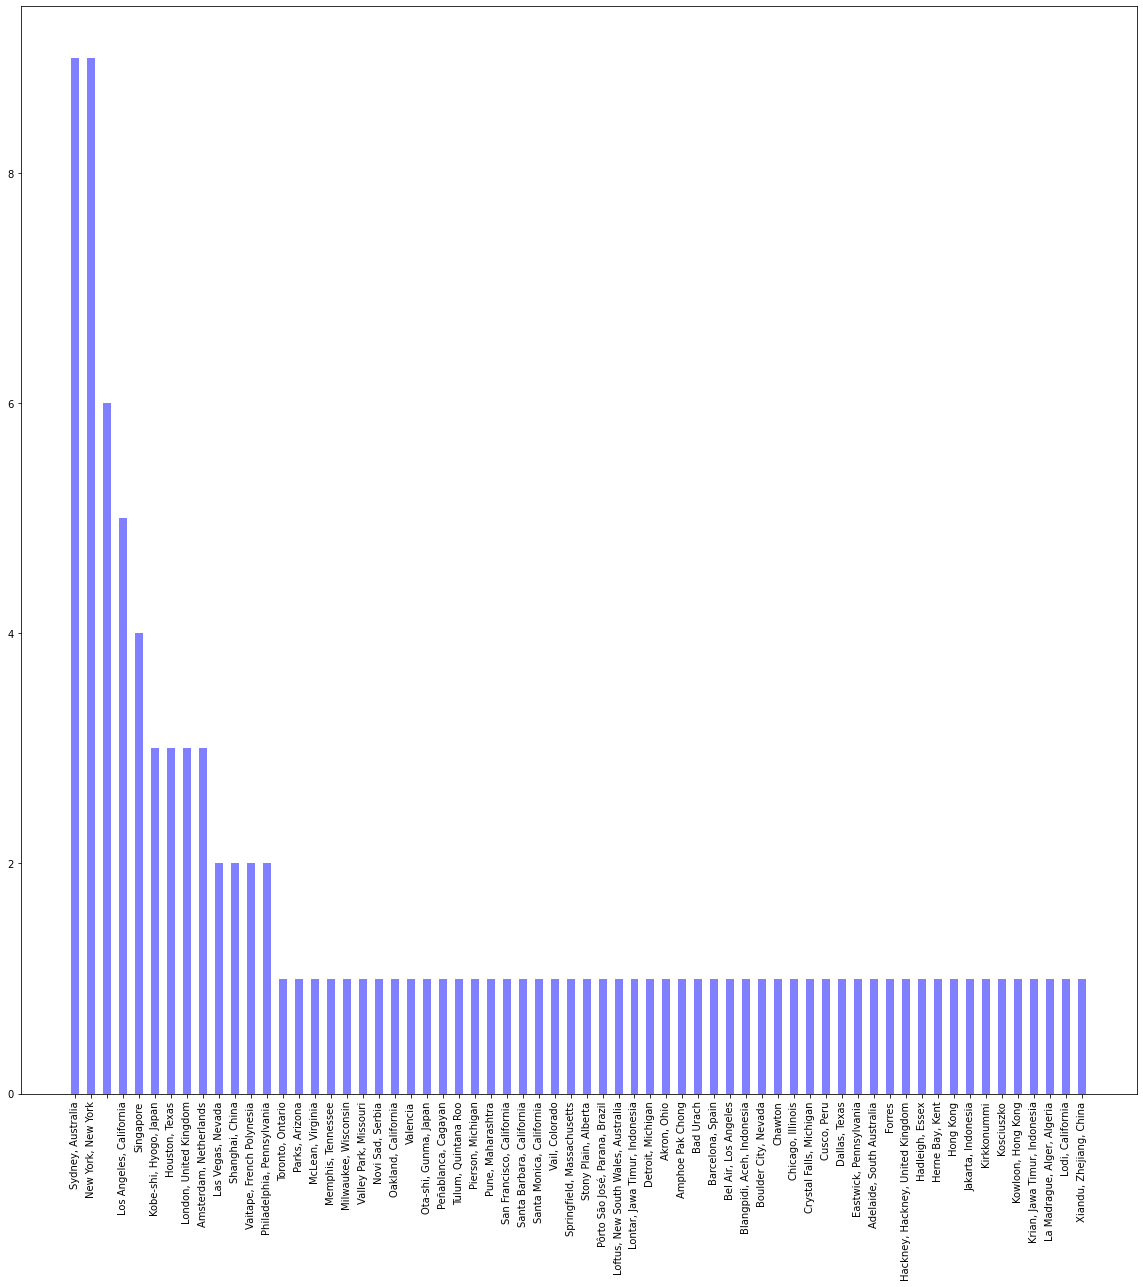

In [50]:
plt.figure(figsize=(20, 20))

ax1=plt.bar(new_df_locations.index,new_df_locations.post_id,width=0.5, alpha=0.5, color='blue')

plt.xticks(new_df_locations.index, new_df_locations.index, rotation='vertical')

plt.show()

## RQ5.4 How many pictures-only posts have they published? How many reels? (only videos) and how many with both contents? Provide the number as percentages and interpret those figures.

In [51]:
#Merge posts and top_profiles on the profile_id
df=pd.merge(posts,top_profiles, on='profile_id')

#select the columns that we are interested in
df=df[['post_id','post_type']]

# Select all the posts that are only pictures
pictures_only=len(df[df.post_type==1])

#Select all the posts that are only reel
reel_only=len(df[df.post_type==2])

#Select all the posts that are both
reel_and_pictures=len(df[df.post_type==3])

#Print out the result
print('pictures_only: ',pictures_only)
print('reel_only: ',reel_only)
print('reel_and_pictures: ',reel_and_pictures)

pictures_only:  92
reel_only:  13
reel_and_pictures:  0


In [52]:
#Let's see how many posts we are dealing with
total_posts=len(df)

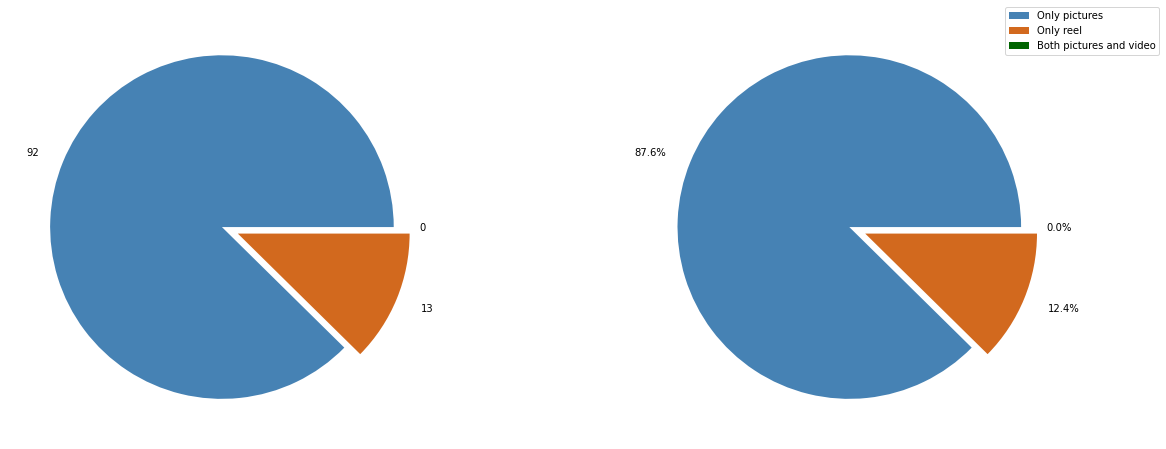

In [53]:
#Showing the result using a pie chart, which is very usefull to catch the difference between the 
pictures_perc='{:.1%}'.format(pictures_only/total_posts)
reel_perc='{:.1%}'.format(reel_only/total_posts)
both_perc='{:.1%}'.format(reel_and_pictures/total_posts)
myexplode=[0.0,0.1,0.0]

#The plots
fig, axs = plt.subplots(1,2)
axs[0].pie([pictures_only,reel_only,reel_and_pictures], labels=[pictures_only,reel_only,reel_and_pictures], 
        labeldistance=1.15, colors=['steelblue','chocolate','darkgreen'], 
           explode=myexplode)
axs[1].pie([pictures_only,reel_only,reel_and_pictures], labels=[pictures_perc,reel_perc,both_perc], 
        labeldistance=1.15, colors=['steelblue','chocolate','darkgreen'], explode=myexplode)
plt.legend(['Only pictures','Only reel','Both pictures and video'], bbox_to_anchor=(0.85,1.025), loc="upper left")

# Some cool features
fig.tight_layout(pad=2.0)
fig.set_figheight(25)
fig.set_figwidth(25)
plt.show() #remove the annoying text

#### Comment of the results

As we can see, there is no top user's post with both pictures and reels. The majority (91.2%) of posts include only pictures, which means that the top user prefers to post mainly pictures, with some exceptions for reels, but never both.

## RQ5.5 How many "likes" and comments did posts with only pictures receive? How about videos and mixed posts? Try to provide the average numbers and confront them with their followers amount, explaining what you can say from that comparison.

In [54]:
#Let's create three datasets, for each post type

df=pd.merge(posts,top_profiles, on='profile_id')
df=df[['post_id','post_type','numbr_likes','number_comments']]

#df with only pictures
df_only_pictures=df[df.post_type == 1]

#df with only reel
df_only_reel=df[df.post_type == 2]

#df with both
df_mixed=df[df.post_type == 3]

In [55]:
#As for the posts including pictures only, let's count how many likes and comments they have 
only_pic_number_of_likes='{:,}'.format(int(df_only_pictures.numbr_likes.sum()))
only_pic_number_of_comments='{:,}'.format(int(df_only_pictures.number_comments.sum()))

#As for the posts including reel only, let's count how many likes and comments they have
only_reel_number_of_likes='{:,}'.format(int(df_only_reel.numbr_likes.sum()))
only_reel_number_of_comments='{:,}'.format(int(df_only_reel.number_comments.sum()))

#As for the posts including both pictures and reels, let's count how many likes and comments they have
mixed_number_of_likes='{:,}'.format(int(df_mixed.numbr_likes.sum()))
mixed_number_of_comments='{:,}'.format(int(df_mixed.number_comments.sum()))

In [56]:
print('The posts with only pictures received',only_pic_number_of_likes,'likes.')
print('The posts with only pictures received',only_pic_number_of_comments,'comments.')
print('The posts with only reels received',only_reel_number_of_likes,'likes.')
print('The posts with only reels received',only_reel_number_of_comments,'comments.')
print('The mixed posts received',mixed_number_of_likes,'likes.')
print('The mixed posts received',mixed_number_of_comments,'comments.')

The posts with only pictures received 45,585,523 likes.
The posts with only pictures received 334,172 comments.
The posts with only reels received 3,464,814 likes.
The posts with only reels received 26,258 comments.
The mixed posts received 0 likes.
The mixed posts received 0 comments.


In [57]:
#Now let's compare the average of likes and comments with the number of followers

#Compute the amount of followers
followers_sum='{:,}'.format(int(top_profiles.followers.sum()))

#Now the average of likes and comments left under only pictures posts
only_pic_mean_number_of_likes='{:,}'.format(int(df_only_pictures.numbr_likes.mean()))
only_pic_mean_number_of_comments='{:,}'.format(int(df_only_pictures.number_comments.mean()))


#Now the average of likes and comments left under only reels posts
only_reel_mean_number_of_likes='{:,}'.format(int(df_only_reel.numbr_likes.mean()))
only_reel_mean_number_of_comments='{:,}'.format(int(df_only_reel.number_comments.mean()))


#Now the average of likes and comments left under mixed posts
mixed_mean_number_of_likes= 0 #since the sum is 0
mixed_mean_number_of_comments=0 #since the sum is 0

perc_only_pic_likes='{:.2%}'.format(int(df_only_pictures.numbr_likes.mean())/int(top_profiles.followers.sum()))
perc_only_pic_comments='{:.3%}'.format(int(df_only_pictures.number_comments.mean())/int(top_profiles.followers.sum()))
perc_only_reel_likes='{:.2%}'.format(int(df_only_reel.numbr_likes.mean())/int(top_profiles.followers.sum()))
perc_only_reel_comments='{:.1%}'.format(int(df_only_reel.number_comments.mean())/int(top_profiles.followers.sum()))
perc_mixed_likes='{:.1%}'.format(0) #since the mean is 0
perc_mixed_comments='{:.1%}'.format(0) #since the mean is 0


In [58]:
print('The total amount of follower is '+str(followers_sum)+'.')
print('')
print('The posts with only pictures received, on average, ',only_pic_mean_number_of_likes,'likes. This means that, on average, the',perc_only_pic_likes,'of the followers have left a like under a post of the top 10 users.')
print('The posts with only pictures received, on average',only_pic_mean_number_of_comments,'comments. This means that, on average, the',perc_only_pic_comments,'of the followers have left a comment under a post of the top 10 users.')
print('')
print('The posts with only reels received, on average',only_reel_mean_number_of_likes,'likes. This means that, on average, the',perc_only_reel_likes,'of the followers have left a like under a post of the top 10 users.')
print('The posts with only reels received, on average',only_reel_mean_number_of_comments,'comments. This means that, on average, the',perc_only_reel_comments,'of the followers have left a comment under a post of the top 10 users.')
print('')
print('The mixed posts received, on average',mixed_mean_number_of_likes,'likes. This means that, on average, the',perc_mixed_likes,'of the followers have left a like under a post of the top 10 users.')
print('The mixed posts received, on average',mixed_mean_number_of_comments,'comments. This means that, on average, the',perc_mixed_comments,'of the followers have left a comment under a post of the top 10 users.')

The total amount of follower is 587,492,835.

The posts with only pictures received, on average,  495,494 likes. This means that, on average, the 0.08% of the followers have left a like under a post of the top 10 users.
The posts with only pictures received, on average 3,632 comments. This means that, on average, the 0.001% of the followers have left a comment under a post of the top 10 users.

The posts with only reels received, on average 266,524 likes. This means that, on average, the 0.05% of the followers have left a like under a post of the top 10 users.
The posts with only reels received, on average 2,019 comments. This means that, on average, the 0.0% of the followers have left a comment under a post of the top 10 users.

The mixed posts received, on average 0 likes. This means that, on average, the 0.0% of the followers have left a like under a post of the top 10 users.
The mixed posts received, on average 0 comments. This means that, on average, the 0.0% of the followers have

# [RQ6] It's time to get information from the user posting effectiveness.

## RQ6.1 What is the average time (days and minutes) a user lets pass before publishing another post? Plot the top 3 users that publish posts more frequently (calculate the average time that passes between posts), including their amount of followers and following. Provide insights from that chart.


In [60]:
#Let's define the columns/variables we are interested in
posts2=posts[['profile_id','cts','post_id']]


In [61]:
# Then we sort and rop all NaN values
posts2=posts2.sort_values(by=['profile_id','cts'],ascending=True)
posts2.dropna(inplace=True)

#Merge the posts and the profile on the key: "profile_id"
new_merge2=pd.merge(posts2,profiles[['profile_id','followers','following']],on='profile_id')

#Let's ignore profiles with no posts or ony 1 post in order to get meaningful sight. If a profile posted only one post, we are not able to compute the time between one post and another.
some=new_merge2.groupby('profile_id').count()
new_some=some[some.cts > 1]
new_some=new_some.sort_values('cts', ascending=True)

#Reset index
new_some=new_some.reset_index()
new_some[['profile_id']]

#Merge the posts and the new_some to get the right "cts"
new_merge=pd.merge(posts2,new_some,on='profile_id')
new_merge=new_merge[['profile_id','cts_x']]
new_merge.rename(columns={'cts_x':'cts'},inplace=True)

In [63]:

diff2=new_merge.set_index('profile_id').diff()

diff2.reset_index(inplace=True)
diff2.drop_duplicates(inplace=True)

diff2=diff2[diff2.cts > np.timedelta64(000000)]

#Reset index
diff2.reset_index(inplace=True)

#Select only the columns i'm interested in
diff2=diff2[['profile_id','cts']]

#group by "profile_id" and do the mean, after that let's sort it in ascending order
AA=diff2.groupby('profile_id').mean().sort_values('cts',ascending=True)
AA.reset_index(inplace=True)
AA=AA.head(3)

these_profiles=AA[['profile_id']]

In [64]:
diff2=new_merge.set_index('profile_id').diff()
diff2.dropna(inplace=True)
diff2.drop_duplicates(inplace=True)
diff2=diff2[diff2.cts > np.timedelta64(000000)]
diff2=diff2.sort_values(['profile_id','cts'],ascending=True)
diff2
#diff2.sort_values(['cts','profile_id'],ascending=False)

,cts
profile_id,
4.000000e+00,0 days 09:27:20
4.000000e+00,1 days 13:04:25
4.000000e+00,1 days 14:58:17
4.000000e+00,1 days 20:05:04
4.000000e+00,3 days 04:12:30
...,...
1.444176e+10,20 days 14:41:07
1.445114e+10,32 days 09:16:06
1.452067e+10,14 days 20:44:41


In [65]:
#Create a copy of diff2
diff3=diff2
diff3.reset_index(inplace=True)
diff3[diff3.profile_id == 14407647.0]

something=diff3.groupby('profile_id').mean().sort_values('cts',ascending=True).head(10)
something.reset_index(inplace=True)

mean_time=diff2['cts'].mean()
time_to_minutes=mean_time.seconds/60
print('The average time (days and minutes) a user lets pass before publishing another post is: '+str(mean_time.days)+' days and '+str(int(time_to_minutes))+ ' minutes.')

#Group By "profile_id" and count
something=diff2.groupby('profile_id').count()

#Reset index
something.reset_index(inplace=True)

The average time (days and minutes) a user lets pass before publishing another post is: 89 days and 774 minutes.


In [67]:
first=profiles[profiles.profile_id == these_profiles.profile_id[0]][['followers','following','profile_name']]
second=profiles[profiles.profile_id == these_profiles.profile_id[1]][['followers','following','profile_name']]
third=profiles[profiles.profile_id == these_profiles.profile_id[2]][['followers','following','profile_name']]

top3=pd.concat([first,second,third])

top3_2=pd.concat([profiles[profiles.profile_name == 'lama_anbar'],profiles[profiles.profile_name == 'nachithogudino'],profiles[profiles.profile_name == 'inafasya77']])

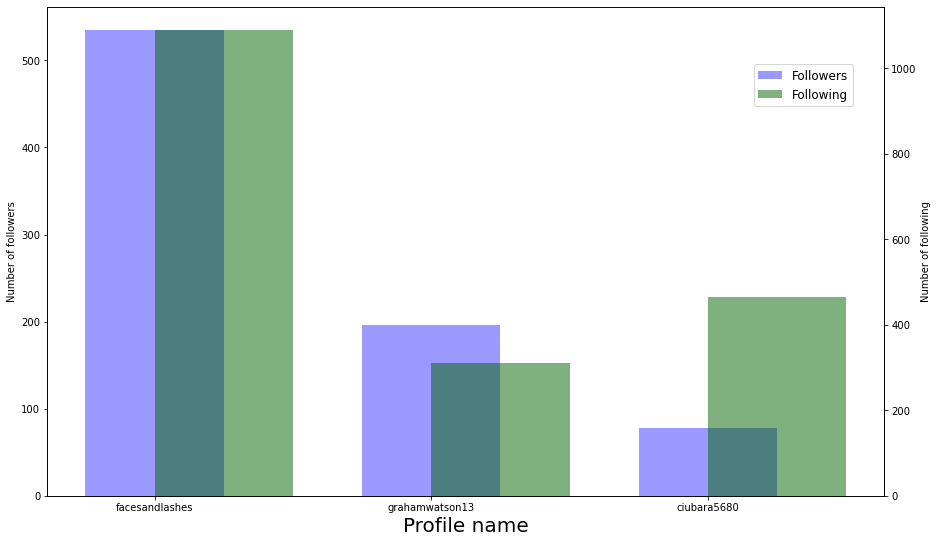

In [68]:
#Now let's plot it

# I'm using white labels because my theme on VS is dark
fig, ax1 = plt.subplots(figsize=(15, 9))
ax1.set_xlabel('Profile name',size=20)
ax1.xaxis.label.set_color('black')
ax1.yaxis.label.set_color('black')
ax1.tick_params(axis='x', colors='black')
ax1.tick_params(axis='y', colors='black')

# plot line chart on axis #1
ax1.bar(top3['profile_name'], top3['followers'], width=0.5, alpha=0.4, color='Blue')
ax1.set_ylabel('Number of followers')
plt.xticks(top3['profile_name'], top3['profile_name'])

# ax1.set_ylim(0, 25)
# set up the 2nd axis

ax2 = ax1.twinx()
ax2.yaxis.label.set_color('black')
ax2.tick_params(axis='y', colors='black')

# plot bar chart on axis #2
ax2.bar(top3['profile_name'], top3['following'], width=0.5, alpha=0.5, color='darkgreen', align='edge')
ax2.grid(False) # turn off grid #2
ax2.set_ylabel('Number of following')
#ax2.set_ylim(0, 90)
fig.legend(['Followers','Following'], loc="upper center",bbox_to_anchor=(0.5, 0.3, 0.65, 0.5),fontsize='large')
plt.show()

## RQ6.2 Using the function you previously coded, plot the time intervals with the highest average number of “likes” and the ones with the highest average number of comments on posts.

In [69]:
first_interval=[['06:00:00'],['10:59:59']]
second_interval=[['11:00:00'],['13:59:59']]
third_interval=[['14:00:00'],['16:59:59']]
fourth_interval=[['17:00:00'],['19:59:59']]
fifth_interval=[['20:00:00'],['23:59:59']]
sixth_interval=[['00:00:00'],['02:59:59']]
seventh_interval=[['03:00:00'],['05:59:59']]
intervals=[first_interval,second_interval,third_interval,fourth_interval,fifth_interval,sixth_interval,seventh_interval]

/Users/the_redd_/Desktop/ADM/ADM-HMW2/functions.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts2['cts'] = pd.to_datetime(posts2['cts']).dt.time
/Users/the_redd_/Desktop/ADM/ADM-HMW2/functions.py:32: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  num=posts2[(posts2.cts < final) & (posts2.cts > initial)].sum()/len(posts2[(posts2.cts < final) & (posts2.cts > initial)])


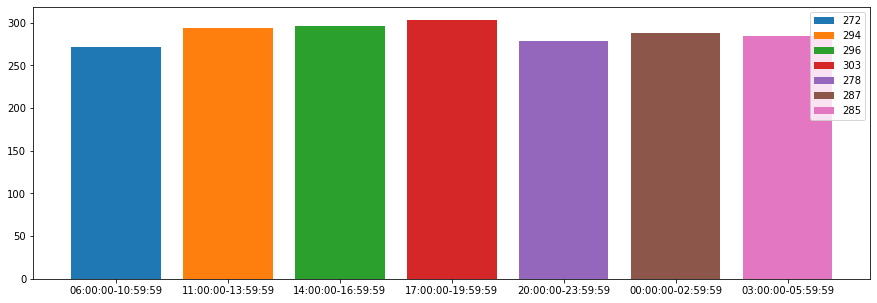

In [70]:
time_intervals(posts,intervals,variable='numbr_likes',mean=True)

/Users/the_redd_/Desktop/ADM/ADM-HMW2/functions.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts2['cts'] = pd.to_datetime(posts2['cts']).dt.time
/Users/the_redd_/Desktop/ADM/ADM-HMW2/functions.py:32: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  num=posts2[(posts2.cts < final) & (posts2.cts > initial)].sum()/len(posts2[(posts2.cts < final) & (posts2.cts > initial)])


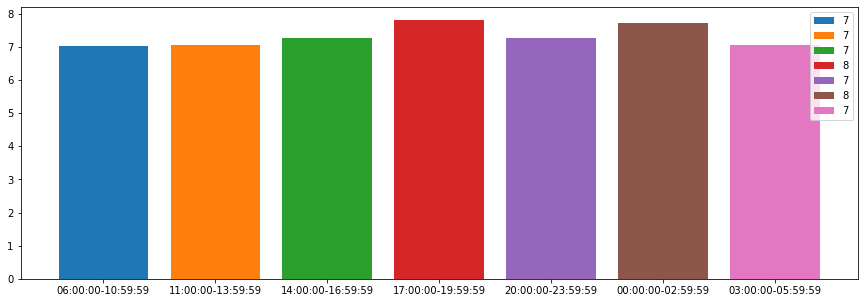

In [71]:
time_intervals(posts,intervals,variable='number_comments',mean=True)

# [RQ7] Of course, calculating probabilities is a job that any Data Scientist must know. So let's compute some engaging figures

## RQ7.1 What's the probability that a post receives more than 20% "likes" of the number of followers a user has?

In [72]:
#Creating two different datasets picking only the columns we are interested in
posts2=posts[['numbr_likes','post_id','profile_id']]
profiles2=profiles[['profile_id','followers']]

# Merging the datasets on the shared column 'profile_id'
df=pd.merge(posts2,profiles2, on='profile_id')

#Considering only profiles with more than 0 followers in order to get meaningful sight
df=df[df.followers != 0]

# We want to compute the number of favourable cases on total cases, so let's get the favourable one
yes_df=df[df.numbr_likes > (df.followers/5)]
yes=len(yes_df)

#Now let's compute
prob=yes/(len(df))


print('The probability that a post receives more than 20% "likes" of the number of followers a user has is equal to: ',"{0:.2%}".format(prob) )

The probability that a post receives more than 20% "likes" of the number of followers a user has is equal to:  14.90%


## RQ7.2 Do users usually return to locations? Extract the probability that a user returns to a site after having posted it in the past. Does that probability make sense to you? Explain why or why not.

We will consider only if a user return at the same location, so we do not care if they return more than twice.

Then, we will count as 1 if a user posted 2 or more posts in two different locations, in order to not get biased.

Regarding the sense of this probability, we think that since a user could post a picture/reel in the same location not being phisically there (for example a memories of an event), this probability *does not* make any sense. Therefore, tagging a particular place or a city makes a lot of difference, since if someone tags the Eiffel Tower and not Paris, the tag would count as a place different than Paris when actually it is not.


In [73]:
posts3=posts[['location_id','profile_id']]
Total_returned_in_location=(sum(posts3.groupby('profile_id',group_keys=True).apply(lambda x: len(x.location_id) != len(set(x.location_id)))))
profiles3=profiles[['profile_id']]
n = len(profiles3)

print('The probability that a user returns to a site after having posted it in the past is: ', np.round(Total_returned_in_location/n,2))

The probability that a user returns to a site after having posted it in the past is:  0.64


# [RQ8] Every decision you take in a data-based environment should be reinforced with charts, statistical tests and analysis methods to check whether a hypothesis is correct or not.

## RQ8.1 Does more “likes” also mean more comments? Plot a scatter plot of “likes” vs comments for posts?

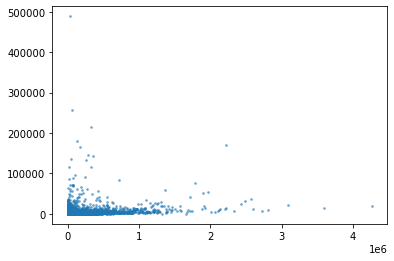

In [74]:
plt.scatter(posts['numbr_likes'], posts['number_comments'],s=3, alpha=0.5)
plt.show()

To have a better understanding of what we are trying to find (the correlation) we are gonna calculate the pearson correlation coefficient

In [75]:
#Pearsonn Correlation
posts.number_comments.corr(posts.numbr_likes)

0.29655215451550293

As we can see from the scatterplot above and the result value from the pearson correlation coefficient. If the number of likes were related to the number of comments then we would be seeing a proportional increase of both value, while from the scatterplot we see that at the increase of the number of likes, the number of comments doesnt increase.

## RQ8.2 Can you find any significant relationship between the time a user publishes a post and the number of comments and “likes”? Use an appropriate statistical test or technique and support your choice.

In [76]:
#lets convert to datetime
posts['cts']=pd.to_datetime(posts['cts'])

#We want to work only on the hours of the publication, not the dates
posts['h'] = posts['cts'].dt.time

# Let's find the pearson correlation between the feature in our df
posts.corr() 

,sid,sid_profile,profile_id,location_id,post_type,numbr_likes,number_comments
sid,1.000000,0.066866,0.003957,0.030844,0.030190,-0.002199,-0.001985
sid_profile,0.066866,1.000000,-0.003103,-0.061304,-0.105066,0.006503,0.003561
profile_id,0.003957,-0.003103,1.000000,0.003289,0.005653,-0.002314,-0.001118
location_id,0.030844,-0.061304,0.003289,1.000000,0.022164,0.000560,0.000789
post_type,0.030190,-0.105066,0.005653,0.022164,1.000000,0.004133,0.004483
numbr_likes,-0.002199,0.006503,-0.002314,0.000560,0.004133,1.000000,0.296552
number_comments,-0.001985,0.003561,-0.001118,0.000789,0.004483,0.296552,1.000000


As we can see there is almost zero correlation between number of likes and the hour, same goes for the number of comments.
The values are respectivly 0.001154 for the number of likes, and 0.000506 for the number of comments. So there is almost zero correlation.

## RQ8.3 What’s the distribution of followers? Plot the empirical distribution of followers amongst all users and extract the mean, mode, and quantiles. Interpret those figures.

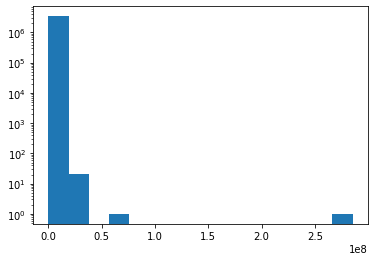

In [82]:
followers=profiles['followers']
plt.hist(followers, log=True, bins=15)
plt.show()

As we can see from the plot above, it is not very clear

For a greater possibility of interpreting the distribution we use the logarithmic scale, but we have many values ​​= 0. To solve this problem we will first increase all the values ​​by 1, in this way we will no longer have values ​​equal to zero and at the same time the distribution remains unchanged .



In [83]:
f_plus_1 = followers.apply(lambda x: x+1)
followers_log = f_plus_1.apply(np.log)

After applying the logarithmic scale, we plot.

<AxesSubplot:xlabel='followers', ylabel='Count'>

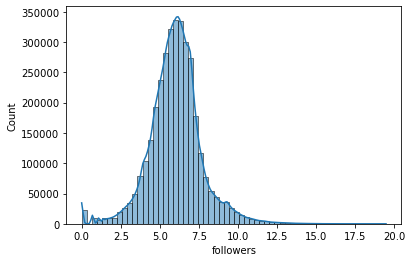

In [87]:
#lets plot the density function of the distribution of followers
sns.histplot( followers_log , kde = True, bins=60)


We extract the mean, mode and quantiles

In [88]:
profiles.followers.describe()

count    3.445317e+06
mean     4.747883e+03
std      1.941182e+05
min      0.000000e+00
25%      1.590000e+02
50%      4.060000e+02
75%      9.740000e+02
max      2.854576e+08
Name: followers, dtype: float64

## RQ8.4 What are histograms, bar plots, scatterplots and pie charts used for?

**Histograms** are useful for seeing the center, distribution, and shape of a data set. They can also be used as a visual tool for support the normality hypotesis.
The horizontal axis represents the data values ​​and each bar includes a range of values. The vertical axis indicates how many points in the data have values ​​within the specified range of the bar.

**Bar plots** are suitable for representing one or more categorical variables. In this type of graph, each mode of the variable (category) is represented by a bar, whose height (or length) is proportional to the frequency or percentage of the mode itself.

A **scatter plot** shows the relationship between two continuous variables. Scatter plots are used to show relationships between data. For correlation, they help show visually the strength of the linear relationship between two variables, while for regression they often add an estimated line. Scatter diagrams are easy to understand and interpret. If there is an upward trend rising from the lower left-hand corner and going upward to the upper right-hand corner, the correlation is positive since this reveals that the values of the two variables move in the same direction. If, on the other hand, the points depict a downward trend from the upper left-hand corner to the lower right-hand corner, the correlation is negative since in this case, the values of the two variables move in the opposite directions.

A **pie chart** is a two-dimensional circle, at its most basic, divided into a few slices. As a whole, the chart represents the sum of all its data; individual slices represents a percentage of the whole. It represents data visually as a fractional part of a whole, which can be an effective communication tool for the even uninformed audience.
It enables the audience to see a data comparison at a glance to make an immediate analysis or to understand information quickly.
The need for readers to examine or measure underlying numbers themselves can be removed by using this chart.
To emphasize points you want to make, you can manipulate pieces of data in the pie chart. If too many pieces of data are used, pie chart becomes less effective.



## RQ8.5 What insights can you extract from a Box Plot?

A Box and Whisker Plot (or Box Plot) is a convenient way of visually displaying the data distribution through their quartiles. It is a graphical rendition of statistical data based on the minimum, first quartile, median, third quartile, and maximum. 

The Boxplot allows us to see graphically:
- Median Value
- Lower Quartile
- Upper Quartile
- Interquartile Range
- Highest value and Lowest Value

The boxplot does not show some features of the distribution such as any peaks or valleys that can be observed with a histogram instead.
This graph also allows you to tell whether the variable you are analyzing has a symmetric or skewed distribution. When the distribution is symmetrical, the first and third quartiles are the same distance from the median. In other words, the median line is exactly in the middle of the box.

The box (the box) is between the first and third quartiles and shows the width of the middle half of the distribution. The height of the box is in fact equal to the interquartile range (IQR) and contains the middle 50% of the observations made, those between the first and third quartiles.

The line inside the box, on the other hand, represents the median.

Whiskers alone should not be relied upon to assess the skewness of a distribution, as their length is affected by the presence of outliers.

## AQ1

In [89]:

def f1(seq, end):
    str = ""                            #1
    for i in range(end):                #N   
        str += seq[i]                   #1              
    print(str)                        #1

def f2(seq, start, end):
    if start == end:                    #1
        f1(seq, end)                    #N!
    else:           
        for i in range(start, end):     #N
            temp = seq[start]           #1
            seq[start] = seq[i]         #1
            seq[i] = temp               #1
            f2(seq, start+1, end,)      #N
            temp = seq[start]           #1
            seq[start] = seq[i]         #1
            seq[i] = temp               #1


## AQ1.1: What is the output of this algorithm? Describe the mechanism of the algorithm in detail . We do not want to know only its final result. (Describe one example on your own)

The purpose of the algorithm is to find every possible permutation of the charaters present in the array. 
The Idea behind this algorithm is to try and generate every possible permutation, starting from the steps right before it: Backtracking.

### More Accurate description of the algorithm:
The first function f1, is just the one to print out the result of each permutation. It will be called at the end of each recursive call of f2. When the attribute 'start' will be equal to the attribute 'end'

The second function f2, is the one responsible for the recursive call for each permutation and the way it works is:
- For each "position" create every possible permutation for the "start" of the array by swapping the start with the i-character of the array. Ex: if we have [a,b,c] it will create [a,b,c], [b,a,c], [c,b,a]
- For every possibility it will call again the recursive function f2, with the modified array and with a greater starting point of start+1. The same process will be repeated until the end of the recursive function
- It is important to understand what the last part of the function f2 does. Once the function swaps the seq[start] with the seq[i] and calls the recursive function, at some point the recursive call will come to an end, and it will go back to the original first call. The last 3 rows inside the 'for loop' are the one responsible to put the value inside the array in their original position before the next iteration of the for loop. This process allow the 'for loop' to modify the array starting from the original one on every iteration.

Example of the first iteration of for loops on the first call of f2:
- Correct possibility of the array: [a,b,c], [b,a,c], [c,b,a]
- Incorrect possibility (without the last 3 row of the for loop): [a,b,c], [b,a,c], [c,a,b]




Below is an example with the array ["a", "b", "c"] and the output relative to the array.

In [90]:
f2(["a","b","c"],0,3)

abc
acb
bac
bca
cba
cab


## AQ1.2: What is asymptotically (i.e., we are asking for big-O complexity) the algorithm's running time as a function of N?

O(N*N!)

The "N" part of the asymptotically time of the algorithm is related to the "for loop" which has at maximum N iteration. While the N! is the time related to the recursive calls of the function f2.

## AQ1.3: Is this algorithm the optimal one to produce this output? If not, can you suggest a better algorithm to perform the same task?

Yes it is the optimal one, as there is no better algorithm for permutation with less than O(N*N!)

## AQ2 : Alex has a ribbon of length N. He wants to cut the ribbon in a way that fulfils the following three conditions:

- Each piece of the cut should have an integer length
- He should at least cut the ribbon once
- The multiplication of the length of all the pieces be the maximum possible

## AQ2.1: Implement a recursive algorithm to help Alex find the maximum possible value after multiplying the length of the pieces. Explain your algorithm in detail.


This algorithm follows the same principle as the algorithm in the exercise AQ1. For every possible permutation of numbers in a range from i to n+1 i append it in an array and then i call the recursive function. 
In this way i will obtain every possible combination of subset that sum up to n. For every iteration of the recursive call i also compute the product of the value inside the array, and if it's greater than what i already have in the
global variable MAX, then i change the value of max to the new greater product.

In [91]:
import math

def findmax(n):              
    max = c([], 1, n)                       #1
    return max                              #1

def c(arr,i,n):
    global counter
    global m
    counter+=1
    if (n==0) and len(arr)>1:               #1
        product = math.prod(arr)            #len(arr) ---> (at most N)
        if product > m:                     #1
            m = product                     #1
    for j in range(i, n+1):                 #N
        counter+=1
        arr.append(j)                       #1
        c(arr, j, n-j)                      #1
        counter+=1
        arr.pop()                           #1
    return m                                #1
    

In [92]:
counter = 0
m = 0
findmax(7)

12

## AQ2.2: Show that the algorithm has exponential running time

To show that the algorithm above has an exponential running time, we will do a demonstration but first we will plot the counters for the recursive part of the algorithm related to the value of n.

We did an example with n going from 2 to 25 

In [93]:
 arrRecursive = []
 for n in range(2, 25):
     counter = 0
     m = 0
     arrRecursive.append(findmax(n))
     print(n, ":", m)
     #print("counter for ", n, ": ", counter)

2 : 1
3 : 2
4 : 4
5 : 6
6 : 9
7 : 12
8 : 18
9 : 27
10 : 36
11 : 54
12 : 81
13 : 108
14 : 162
15 : 243
16 : 324
17 : 486
18 : 729
19 : 972
20 : 1458
21 : 2187
22 : 2916
23 : 4374
24 : 6561


In [94]:
exponential = []
def expo(n):
    return 2**n

for x in range(2,25):
    exponential.append(expo(x))

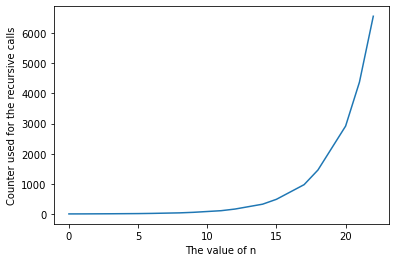

In [95]:
import matplotlib.pyplot as plt
plt.plot(arrRecursive)
plt.xlabel("The value of n")
plt.ylabel("Counter used for the recursive calls")
plt.show()

The recursive function gets called at 2**N times, so the fucntion is O(2^N) )


## AQ2.3: Now provide a polynomial solution, based on dynamic programming, and compute its running-time complexity.


In [96]:
def dynProg(n):
    #base case
    arr = [-1,-1]
    arr.append(1)
    counter = 1
    for x in range(3, n+1):
        counter += 1
        arr.append(x//2 * (x//2+ x%2))
        for y in range(x-1, 2, -1):
            counter += 1
            if arr[x] < (arr[y])*(x-y):
                arr[x] = arr[y]*(x-y)
    return arr[n], counter


The Polynomial solution has a double foor loop with max n repetition, so the it's running time complexity shoud be O(N**2)b

In [97]:
dynProg(8)

(18, 22)

## AQ2.4 Evaluate the running time of your algorithm for the sizes (Ns) in the range of [2, 25], plot the results, and interpret it (if you have implemented two algorithms, please include both in the plot and compare them).

In [98]:
arrDynProg = []
for n in range(2, 25):
    arrDynProg.append(dynProg(n)[1])

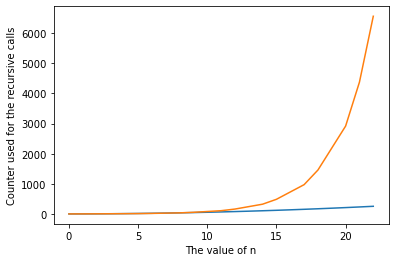

In [99]:
import matplotlib.pyplot as plt
plt.plot(arrDynProg)
plt.plot(arrRecursive)
#plt.plot(range(1,50))
plt.xlabel("The value of n")
plt.ylabel("Counter used for the recursive calls")
plt.show()

## AQ2.5 (Optional, mini bonus) Is the algorithm of question 3 optimal? If you belive it, can you prove it? If not, can you find a faster algorithm? In case you found a faster algorithm implement it and explain your algorithm in detail.

The dynamic programming algorithm is not the optimal one, as this problem can be solved only by solving an equation.

The idea behind the following algorithm is that the max product of subpart of n is the product obtain with pieces of lenght 3 and 2. 
So the only check that we need to do, is to see if the number is divided by 3 and if not we need to do small fixes to the original formula

In [100]:
def optimal(n):
    r = n%3
    #original formula
    if r == 0:
        return 3**(n//3)
    #if the rest of the division is 1, then we need to remove one "3" from the final product and sum 3 with the rest of the divison, in this way we will have 3+1=4, that becomes 2 x 2 x 3^((n%3)-1)
    elif r == 1:
        return 3**((n//3)-1)*4
    #if the rest is 2, then we only need to add *2 at the end of the formula
    elif r == 2:
        return 3**((n//3))*2

In [101]:
for x in range(2,25):
     print(x, " :", optimal(x))

2  : 2
3  : 3
4  : 4
5  : 6
6  : 9
7  : 12
8  : 18
9  : 27
10  : 36
11  : 54
12  : 81
13  : 108
14  : 162
15  : 243
16  : 324
17  : 486
18  : 729
19  : 972
20  : 1458
21  : 2187
22  : 2916
23  : 4374
24  : 6561


## C - Implement a text data analysis (also known as text mining) of the field "description" from instagram_posts.csv for descriptions written in English. Use appropriate visualizations and statistics to highlight the words (and probably the topics) provided for the users in that field.

In [102]:
descriptions = pd.read_csv("instagram_posts.csv", delimiter='\t', dtype = {'description': 'string'}, usecols=['description'], chunksize=100000)
p = descriptions.get_chunk(100000)

In [103]:


def count_word(arr):
    #d = enchant.Dict("en_US")
    counts = dict()
    for description in arr.iterrows():
        for word in description[1].to_string().split():
            #check if the word is in english
            if len(word) > 2:
                if word in counts:
                    counts[word] += 1
                else:
                    counts[word] = 1
    return counts


In [104]:
dic = count_word(p)

In [105]:
dic.pop('description')

100003

In [106]:
arr = []
for x in dic.keys():
    if len(x) < 3:
        arr.append(x)

for x in arr:
    dic.pop(x)

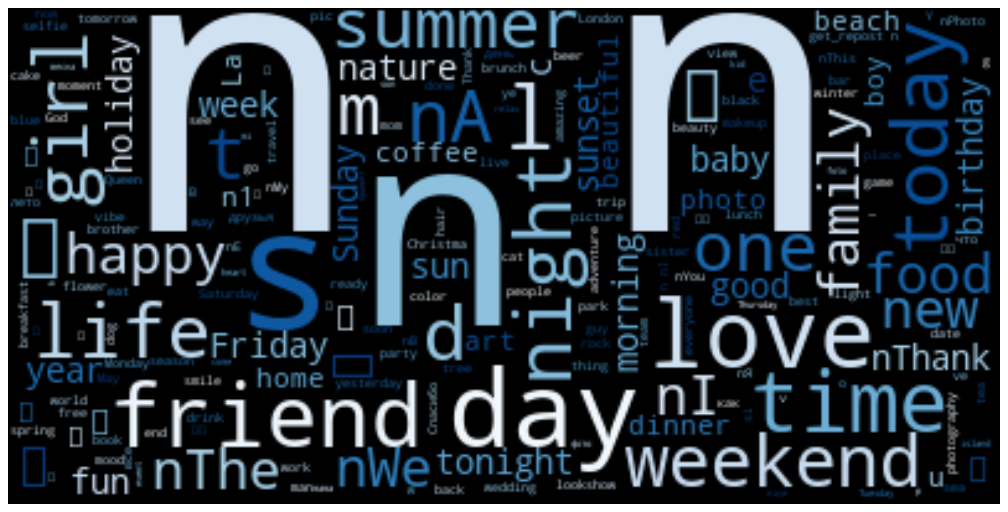

In [110]:

figure(figsize=(16, 12), dpi=80)
text = " ".join([(k + " ") for k,v in dic.items() if len(k) > 2])

text = text.replace('\'', "")
text = text.replace(".", "")
text = text.replace("-", "")

text = text.split()

text = " ".join([(k + " ") for k in text if len(k) > 2])




# Generate a word cloud image
wordcloud = WordCloud(colormap="Blues").generate(text)


# Display the generated image:
# the matplotlib way
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()